In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os
from functools import reduce
import pickle
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
from evaluation import *

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
def create_ap_df(ingredients, ap_list, column='tfidf_ap'):
    df = pd.DataFrame.from_dict(dict(zip(ingredients, ap_list)).items())
    df.columns = ['ingredient', column]
    return df

In [5]:
# Set input file directory
import joblib
from pathlib import Path
PATH = Path("")
data_path = PATH.home()/'data/Target/data/'
model_path = PATH.home()/'data/Target/models/group4'
recipe_path = data_path/"layer1.json"

# Get grocery product hierarchy information
group4 = pd.read_csv(os.path.join(data_path, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(data_path,
                                    'products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group4, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

In [6]:
group4['title_lower'] = group4['title'].str.lower()

In [7]:
# Find relevant pan products
pan_docs = group4[((group4['sub_group_name'] == 'KITCHEN')  
                   & (group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets'])))]

# Find relevant saucepan products
saucepan_docs = group4[((group4['sub_group_name'] == 'KITCHEN') 
                   & (group4['subclass_name'] == 'SAUCEPAN') 
                   & (group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets'])))]

# Find relevant skillet products
skillet_docs = group4[((group4['sub_group_name'] == 'KITCHEN')
                   & ((group4['title_lower'].str.contains('skillet'))
                   & (group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets'])))
                   | ((group4['class_name'] == 'SMALL APPLIANCES') & (group4['item_type_name'] == 'Electric Skillets')))]

# Find relevant Pot products
pot_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
                & ((group4['subclass_name'].isin(['STOCK POT','STOCKPOT']))
                   |((group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets']))
                    & (group4['title_lower'].str.contains('stock pot'))))]

# Find relevant bowl products
bowl_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'SERVING BOWL')) 
                    |((group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Mixing Bowls'))
                    |((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'MIXING BOWLS')) ]

# Find relevant colander products
colander_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'COLANDER')) 
                      |((group4['sub_group_name'] == 'KITCHEN')
                    & (group4['item_type_name'].isin(['Colanders','Strainers'])))]

# Find relevant whisk products
whisk_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'WHISK')) 
                   |((group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name']=='Whisks'))]

# Find relevant griddle products
griddle_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
                     & ((group4['subclass_name'] == 'GRIDDLE') 
                       |(group4['item_type_name']=='Grill Pans and Griddles')
                       |((group4['class_name'] == 'SMALL APPLIANCES') & (group4['item_type_name'] == 'Electric Griddles' )))]

                  
# Find relevant Wok products
wok_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
                & ((group4['subclass_name'].isin(['WOK PAN','WOKPAN']))
                 |((group4['class_name'] == 'SMALL APPLIANCES') & (group4['item_type_name'] == 'Electric Woks')))] 

# Find relevant KNIFE products
knife_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['title_lower'].str.contains('knife'))] 
                   
# Find relevant graters
grate_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Graters')] 

# Find relevant mortar & pestle
mrtrpestle_docs = group4[(group4['sub_group_name'] == 'KITCHEN')
                         & (group4['item_type_name'] == 'Mortars and Pestles')] 

# Find relevant Blender products
blender_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'].isin(['BLENDER','HAND BLENDER']))) 
                      |((group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name']=='Blenders'))]

# Find relevant basting brushes
brush_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
            & (group4['item_type_name'].isin(['Basting Brushes','Vegetable Brushes']))] 

# Find relevant Spatula products
spatula_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] =='SPATULA')] 

# Find relevant sPOON products
spoon_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] =='Kitchen Spoons')] 

# Find relevant Cup products
cup_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Measuring Cups')] 

# Find relevant Sheets products
sheet_docs = group4[((group4['class_name'] == 'BAKEWARE') & (group4['product_subtype_name'] == 'COOKWARE AND BAKEWARE')
            & (group4['item_type_name']== 'Bakeware Sets')) 
            | ((group4['class_name'] == 'FOOD STORAGE') & (group4['item_type_name']=='Food Wraps'))]


# Find relevant dish products
dish_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Baking Dishes')] 
                    
# Get product list from docs
pan_relevant_docs = list(pan_docs['tcin'].values)
bowl_relevant_docs = list(bowl_docs['tcin'].values)
colander_relevant_docs = list(colander_docs['tcin'].values)
whisk_relevant_docs = list(whisk_docs['tcin'].values)
griddle_relevant_docs = list(griddle_docs['tcin'].values)
skillet_relevant_docs = list(skillet_docs['tcin'].values)
wok_relevant_docs = list(wok_docs['tcin'].values)
knife_relevant_docs = list(knife_docs['tcin'].values)
grate_relevant_docs = list(grate_docs['tcin'].values)
mortar_pestle_relevant_docs = list(mrtrpestle_docs['tcin'].values)
blender_relevant_docs = list(blender_docs['tcin'].values)
brush_relevant_docs = list(brush_docs['tcin'].values)
spatula_relevant_docs = list(spatula_docs['tcin'].values)
spoon_relevant_docs = list(spoon_docs['tcin'].values)
cup_relevant_docs = list(cup_docs['tcin'].values)
saucepan_relevant_docs = list(saucepan_docs['tcin'].values)
sheet_relevant_docs = list(sheet_docs['tcin'].values)
dish_relevant_docs = list(dish_docs['tcin'].values)
pot_relevant_docs = list(pot_docs['tcin'].values)

# Create ingredient and relevant products mapping
ingredient_docs_map = {}
ingredient_docs_map = dict.fromkeys(['pan'], pan_relevant_docs)
ingredient_docs_map.update(dict.fromkeys(['bowl'], bowl_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['colander'], colander_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['whisk'], whisk_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['griddle'], griddle_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['skillet'], skillet_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['wok'], wok_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['knife'], knife_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['grate'], grate_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['mortar & pestle'], mortar_pestle_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['blender'], blender_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['brush'], brush_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['spatula'], spatula_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['spoon'], spoon_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['cup'], cup_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['saucepan'], saucepan_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['sheet', 'baking sheet'], sheet_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['dish', 'baking dish'], dish_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['pot','stock pot'], pot_relevant_docs))                                        

In [8]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
    return stored_data
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

# Get list of preprocessed product titles
product_titles = group4['title'].str.lower().values

In [27]:
k=3

# Bi Encoder
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# Cross encoder 
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
multi_lm_embeddings = get_embeddings(data_path/'hier_embeddings_products4.pkl')
roberta_embedder = SentenceTransformer('all-distilroberta-v1')
roberta_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/roberta_embeddings_products4.pkl')

In [13]:
# Get rankings for multiple ingredients
ingredients = ingredient_docs_map.keys()
relevant_docs_list = ingredient_docs_map.values()


In [17]:
# # Get embeddings for Sentence Transformers 
# lm_embedder = SentenceTransformer('all-MiniLM-L6-v2')
# glove_embedder = SentenceTransformer('average_word_embeddings_glove.6B.300d')
# multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# mpnet_embedder = SentenceTransformer('all-mpnet-base-v2')
# roberta_embedder = SentenceTransformer('all-distilroberta-v1')

# all_matches = group4['title_lower'].values

In [10]:
# glove_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/glove_embeddings_products4.pkl')
# lm_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/lm_embeddings_products4.pkl')
# multi_lm_embeddings = get_embeddings('../../data/embeddings/hier_embeddings_products4.pkl')
# mpnet_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/mpnet_embeddings_products4.pkl')
# roberta_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/roberta_embeddings_products4.pkl')

In [14]:
pm = Mapper(group4)
clf_name_class_name = model_path/'nli-classification-class_name'
clf_name_item_type_name = model_path/'nli-classification-item_type_name'
clf_name_subclass_name = model_path/'nli-classification-subclass_name'

embedding_loc = data_path/'hier_embeddings_products4.pkl'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [29]:
filtered_products = list(group4[~pd.isnull(group4['image'])]['tcin'].values)

#Roberta
roberta = TransformerRanker(model=roberta_embedder, max_rank=k)
roberta.load_embeddings(roberta_embeddings)


# Bi encoder
multi_lm = TransformerRanker(model=multi_lm_embedder, 
                             max_rank=k,
                             filtered_products=filtered_products)
multi_lm.load_embeddings(multi_lm_embeddings)

# Bi encoder with classifier
multi_lm_clf = TransformerRanker(model=multi_lm_embedder,
                             max_rank=k, clf=[clf_class_name, 
                                              clf_item_type_name,
                                              clf_subclass_name],
                             filtered_products=filtered_products)
multi_lm_clf.load_embeddings(multi_lm_embeddings)

# cross_encoder_model
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)

# Cross encoder with classifier
cr_multi_lm_clf = CrossEncoderRanker(bi_model=multi_lm_clf, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)                

In [30]:
roberta_ranker_lists = roberta.rank_products_recipe(ingredients)

In [24]:
multi_lm_ranker_lists = multi_lm.rank_products_recipe(ingredients)
multi_lm_clf_ranker_lists = multi_lm_clf.rank_products_recipe(ingredients)

Filtered pan for class_name: BTC CART
Filtered pan for item_type_name: Indoor Trash Cans
Filtered colander for class_name: FASHION OFFICE
Filtered whisk for class_name: FASHION OFFICE
Filtered wok for item_type_name: Indoor Trash Cans
Filtered grate for class_name: FASHION OFFICE
Filtered blender for class_name: GRILLS
Filtered spatula for class_name: FASHION OFFICE
Filtered spatula for item_type_name: Manual Sharpeners
Filtered saucepan for class_name: BTC CART
Filtered saucepan for item_type_name: Indoor Trash Cans
Filtered baking sheet sheet for class_name: ASTV
Filtered pot for item_type_name: Indoor Trash Cans
Filtered stock pot stock for class_name: BTC CART
Filtered stock pot stock for item_type_name: Indoor Trash Cans


In [25]:
cr_multi_lm_ranker_lists = cr_multi_lm.rank_products_recipe(ingredients)
cr_multi_lm_clf_ranker_lists = cr_multi_lm_clf.rank_products_recipe(ingredients)

Filtered pan for class_name: BTC CART
Filtered pan for item_type_name: Indoor Trash Cans
Filtered colander for class_name: FASHION OFFICE
Filtered whisk for class_name: FASHION OFFICE
Filtered wok for item_type_name: Indoor Trash Cans
Filtered grate for class_name: FASHION OFFICE
Filtered blender for class_name: GRILLS
Filtered spatula for class_name: FASHION OFFICE
Filtered spatula for item_type_name: Manual Sharpeners
Filtered saucepan for class_name: BTC CART
Filtered saucepan for item_type_name: Indoor Trash Cans
Filtered baking sheet sheet for class_name: ASTV
Filtered pot for item_type_name: Indoor Trash Cans
Filtered stock pot stock for class_name: BTC CART
Filtered stock pot stock for item_type_name: Indoor Trash Cans


In [31]:
# Roberta rankings
roberta_map, roberta_ap = mean_average_precision(roberta_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Roberta MAP: {roberta_map:.2f}')

print('Sentence Transformers (L1 Ranker):')
# Multi LM rankings
multi_lm_map, multi_lm_ap = mean_average_precision(multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM MAP: {multi_lm_map:.2f}')

# Multi LM CLF rankings
multi_lm_clf_map, multi_lm_clf_ap = mean_average_precision(multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM CLF MAP: {multi_lm_clf_map:.2f}')

print('\nSentence Transformers (L2 Ranker):')
# CR Multi LM rankings
cr_multi_lm_map, cr_multi_lm_ap = mean_average_precision(cr_multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM  MAP: {cr_multi_lm_map:.2f}')

# CR Multi LM CLF rankings
cr_multi_lm_clf_map, cr_multi_lm_clf_ap = mean_average_precision(cr_multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM CLF MAP: {cr_multi_lm_clf_map:.2f}')

Roberta MAP: 0.80
Sentence Transformers (L1 Ranker):
Multi LM MAP: 0.89
Multi LM CLF MAP: 0.89

Sentence Transformers (L2 Ranker):
CR Multi LM  MAP: 0.82
CR Multi LM CLF MAP: 0.82


boiler
[84095732, 79992496, 79992492, 79992490, 82213254, 82213252, 82826428, 82826419, 79707527, 82797952]


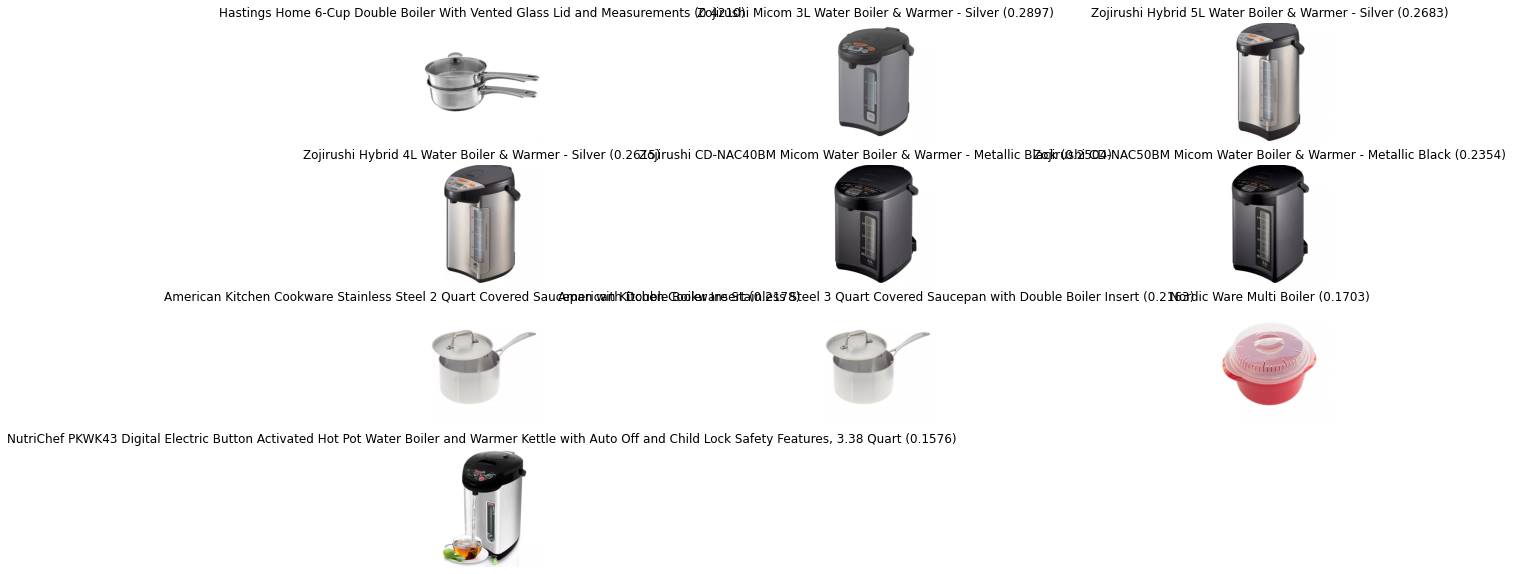

In [19]:
dp = DisplayProducts(ranker=cr_multi_lm, mapper=pm)
dp.display_products_ingredient('boiler', 10)

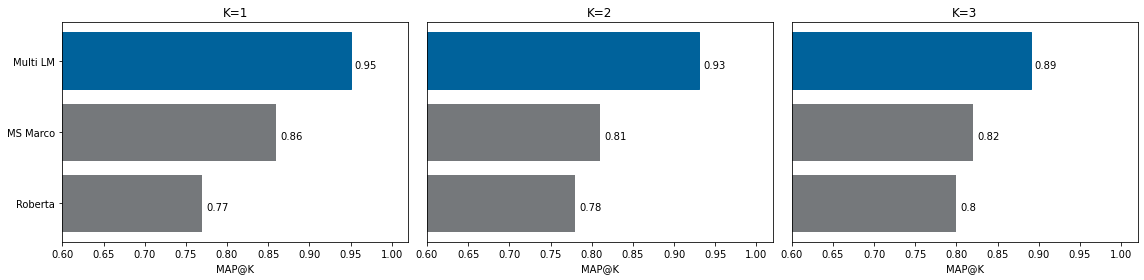

In [35]:
import matplotlib.pyplot as plt

# names = ['BM25', 'Multi LM', 'MS Marco', 'BM25 + Multi LM', 'BM25 + MS Marco']
# ranker_lists = [bm25_ranker_list, multi_lm_ranker_lists, cr_multi_lm_ranker_lists, rc_ranker_list, rp_ranker_list]
names = ['Roberta','MS Marco', 'Multi LM']
ranker_lists = [roberta_ranker_lists, cr_multi_lm_clf_ranker_lists, multi_lm_clf_ranker_lists]
overall_df = pd.DataFrame()
for name, ranker_list in zip(names, ranker_lists):
    map_list = []
    for k in range(1, 4):
        temp_list = [rank_list[0:k] for rank_list in ranker_list]
        map, ap = mean_average_precision(temp_list, 
                                            relevant_docs_list, 
                                            return_ap = True)
        map_list.append(round(map, 2))
    df = pd.DataFrame()
    df['MAP'] = map_list
    df['k'] = list(range(1,4))
    df['model'] = name
    overall_df = pd.concat([overall_df, df])

fig, axes = plt.subplots(figsize=(16, 4), ncols=3)
ax = axes.flatten()
axes[0].get_shared_y_axes().join(axes[0], *axes[1:])

for i in range(0, 3):
    df_k = overall_df[overall_df['k'] == i+1]
    bars = ax[i].barh(df_k['model'], df_k['MAP'], color='#75787B')
    for j, bar in enumerate(bars):
        if j==len(bars)-1:
            bar.set_color('#00629B')
        yval = bar.get_width()
        axes[i].text(yval + 0.005, bar.get_y() + 0.3, yval)      
    ax[i].set_title(f'K={i+1}')
    ax[i].set_xlabel('MAP@K')
    ax[i].set_xlim(0.6, 1.02)
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_yticks([])

plt.tight_layout()
plt.savefig('Ingredient Search Results.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

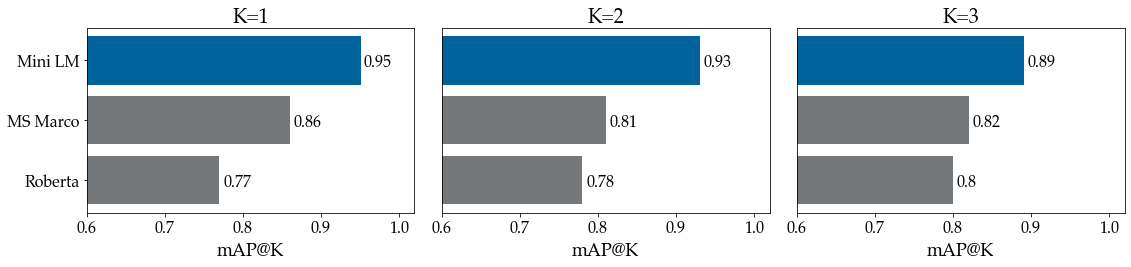

In [37]:
import matplotlib.pyplot as plt
from matplotlib import rc

small_size = 16
medium_size = 18
large_size = 20

rc('font',**{'family':'sans-serif','sans-serif':['Palatino']}) 

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=large_size,
               labelsize=medium_size)     # fontsize of the axes title
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=large_size)   # fontsize of the figure title

names = ['Roberta','MS Marco', 'Mini LM']
ranker_lists = [roberta_ranker_lists, cr_multi_lm_clf_ranker_lists, multi_lm_clf_ranker_lists]
overall_df = pd.DataFrame()
for name, ranker_list in zip(names, ranker_lists):
    map_list = []
    for k in range(1, 4):
        temp_list = [rank_list[0:k] for rank_list in ranker_list]
        map, ap = mean_average_precision(temp_list, 
                                            relevant_docs_list, 
                                            return_ap = True)
        map_list.append(round(map, 2))
    df = pd.DataFrame()
    df['MAP'] = map_list
    df['k'] = list(range(1,4))
    df['model'] = name
    overall_df = pd.concat([overall_df, df])

fig, axes = plt.subplots(figsize=(16, 4), ncols=3)
ax = axes.flatten()
axes[0].get_shared_y_axes().join(axes[0], *axes[1:])

for i in range(0, 3):
    df_k = overall_df[overall_df['k'] == i+1]
    bars = ax[i].barh(df_k['model'], df_k['MAP'], color='#75787B')
    for j, bar in enumerate(bars):
        if j==len(bars)-1:
            bar.set_color('#00629B')
        yval = bar.get_width()
        axes[i].text(yval + 0.005, bar.get_y() + 0.3, yval)      
    ax[i].set_title(f'K={i+1}')
    ax[i].set_xlabel('mAP@K')
    ax[i].set_xlim(0.6, 1.02)
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_yticks([])

plt.tight_layout()
plt.savefig('Kitchen Gadgets Results.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
